<a href="https://colab.research.google.com/github/Mahdi-Saadati/Advanced-Machine-Learning-and-Deep-Neural-Networks/blob/main/11.a.%20Graph%20Neural%20Network%20(GNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir="rtl" align="right">

شبکه عصبی گرافی (Graph Neural Network (GNN))


1️⃣ گراف چیست؟

یک گراف شامل گره‌ها (Nodes) و یال‌ها (Edges) است.

مثال پزشکی:

گره‌ها: پروتئین‌ها یا ژن‌ها

یال‌ها: تعامل بین پروتئین‌ها یا ارتباط ژن‌ها

2️⃣ مسئله شبکه‌های عصبی معمولی

شبکه‌های عصبی استاندارد (مثل CNN یا MLP) روی داده‌های جدول یا تصویر خوب کار می‌کنند.

اما گراف‌ها ساختار پیچیده و نامنظم دارند (تعداد همسایه‌ها متفاوت است، ترتیب مشخص نیست).

3️⃣ ایده اصلی GNN

هر گره ویژگی‌هایی دارد (مثلاً بیان ژن یا فعالیت پروتئین)

هر گره با گره‌های همسایه‌اش ارتباط دارد

GNN ویژگی جدید هر گره را با ترکیب اطلاعات خودش و همسایه‌ها محاسبه می‌کند

به زبان ساده:
هر گره می‌بیند "همسایه‌هایم چه ویژگی‌ای دارند؟" و سپس ویژگی خودش را به روز می‌کند.

4️⃣ فرآیند یک لایه GNN (مثل GCN)

برای هر گره، ویژگی‌های خودش و همه همسایه‌هایش را جمع یا میانگین می‌گیریم

یک وزن یادگرفتنی روی این ویژگی‌ها اعمال می‌کنیم (مثل شبکه عصبی معمولی)

یک تابع فعال‌سازی (مثل ReLU) می‌گذاریم

خروجی، ویژگی جدید گره‌ها است

این کار را می‌توان در چند لایه تکرار کرد تا هر گره اطلاعاتی از همسایه‌های دورتر هم بگیرد.

5️⃣ مثال ساده ذهنی

فرض کن گراف یک شبکه دوستانه باشد:

هر فرد (گره) یک علاقه دارد (ویژگی)

هر فرد با دوستانش (یال) تعامل دارد

یک لایه GNN می‌گوید: "علاقه جدید من = میانگین علاقه‌های دوستانم + علاقه خودم"

بعد از چند لایه، هر فرد ویژگی‌ای دارد که بازتاب کل شبکه دوستانش است.

6️⃣ در پزشکی

گره = ژن یا پروتئین

یال = تعامل بین آن‌ها

GNN می‌تواند پیش‌بینی کند:

ژن‌ها با هم در چه مسیرهای بیوشیمیایی فعالیت دارند

پروتئین‌ها چه نقش مشترکی دارند

بیماری‌ها چه ژن‌ها یا پروتئین‌هایی را تحت تأثیر قرار می‌دهند



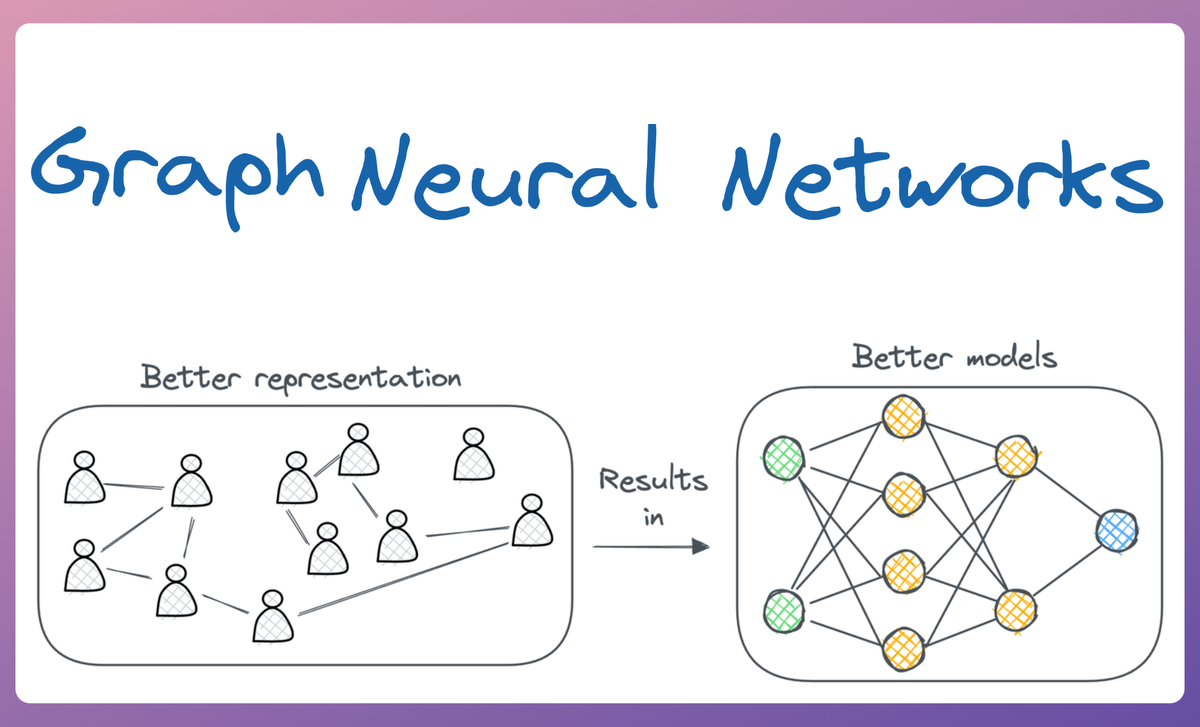


<div dir="rtl" align="right">

📌 مسئله: فرض کن یک شبکه اجتماعی کوچیک داریم (چند نفر با هم دوست هستند).
هر نفر یک ویژگی داره:

0 = اهل فیلم 🎬

1 = اهل ورزش 🏃

حالا می‌خوایم با یک شبکه عصبی گرافی (GCN) پیش‌بینی کنیم هر نفر به کدام گروه تعلق دارد، فقط با توجه به دوستانش.

In [15]:
import torch                     # کتابخانه اصلی PyTorch برای کار با تنسورها و مدل‌ها
import torch.nn as nn            # زیرکتابخانه برای تعریف شبکه‌های عصبی
import torch.nn.functional as F  # توابع آماده مثل ReLU
from torch_geometric.nn import GCNConv  # لایه آماده برای شبکه عصبی گرافی (GCN)
from torch_geometric.data import Data   # ساختار داده مخصوص گراف در PyG

# ---------------- تعریف گراف ----------------

# ماتریس ویژگی گره‌ها (node features)
# ما 4 گره داریم و هر گره یک بردار 2تایی ویژگی دارد
x = torch.tensor([[1, 0],   # ویژگی‌های گره 0
                  [0, 1],   # ویژگی‌های گره 1
                  [1, 1],   # ویژگی‌های گره 2
                  [0, 0]],  # ویژگی‌های گره 3
                 dtype=torch.float)

# تعریف یال‌ها (edge list)
# edge_index باید 2×E باشد (E = تعداد یال‌ها)
# هر ستون نشان‌دهنده یک یال (from → to) است
edge_index = torch.tensor([[0, 1, 2, 1, 2, 3],   # گره مبدا (from)
                           [1, 0, 1, 2, 3, 2]],  # گره مقصد (to)
                           dtype=torch.long)
# یعنی یال‌ها اینطورند:
# 0→1 ، 1→0 ، 2→1 ، 1→2 ، 2→3 ، 3→2

# حالا یک شیء گراف می‌سازیم که شامل ویژگی گره‌ها و یال‌ها باشد
data = Data(x=x, edge_index=edge_index)

# ---------------- تعریف مدل GCN ----------------
class SimpleGCN(nn.Module):           # یک شبکه ساده که از nn.Module ارث‌بری می‌کند
    def __init__(self):
        super(SimpleGCN, self).__init__()
        # یک لایه GCN تعریف می‌کنیم:
        # ورودی 2 ویژگی دارد → خروجی هم 2 ویژگی می‌سازیم
        self.conv1 = GCNConv(2, 2)

    def forward(self, x, edge_index):
        # اجرای لایه GCN روی گراف
        x = self.conv1(x, edge_index)
        # روی خروجی تابع ReLU اعمال می‌کنیم
        return F.relu(x)

# ساخت مدل
model = SimpleGCN()

# اجرای مدل روی داده‌ی گراف
out = model(data.x, data.edge_index)

# چاپ نتایج
print("New features of nodes after GCN:")
print(out)


New features of nodes after GCN:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<ReluBackward0>)


<div dir="rtl" align="right">

🔎 خلاصه ساده:

4 گره داریم که هرکدام 2 ویژگی اولیه دارند.

بین گره‌ها یال‌هایی تعریف شده (مثلاً 0↔1 و 2↔3).

یک لایه GCN می‌سازیم که اطلاعات هر گره را با همسایه‌هایش ترکیب می‌کند.

بعد از اجرای مدل، هر گره ویژگی‌های جدیدی پیدا می‌کند (بردار جدید).


📊 خروجی مورد انتظار:
برچسب واقعی: [0, 1, 0, 1]

مدل بعد از یادگیری باید تقریباً همین مقادیر رو درست پیش‌بینی کنه.

🔑 این یک مثال ساده و کاربردی بود:

گراف = شبکه اجتماعی

ویژگی = علاقه اولیه

برچسب = گروه واقعی (فیلم یا ورزش)

هدف = پیش‌بینی علاقه افراد ناشناخته بر اساس دوستانشان

